In [1]:
import pandas as pd

In [2]:
df = pd.DataFrame([], columns=['a', 'b'])

In [3]:
df

,a,b


In [4]:
df.loc[0] = [1, 2]
df.loc[1] = [3, 4]

In [8]:
for x in df.itertuples():
    print(type(x))
    print(x)

<class 'pandas.core.frame.Pandas'>
Pandas(Index=0, a=1, b=2)
<class 'pandas.core.frame.Pandas'>
Pandas(Index=1, a=3, b=4)


In [2]:
import numpy as np

x = ["a", "a", "b", "a", "c"]
print(np.unique(x, return_inverse=True))

(array(['a', 'b', 'c'], dtype='<U1'), array([0, 0, 1, 0, 2], dtype=int64))


In [7]:
import pickle
import numpy as np
from hyperopt import Trials
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

with open("bayes_trials_200.bin", "rb") as f:
    trials = pickle.load(f)

In [2]:
losses = - np.array(trials.losses())

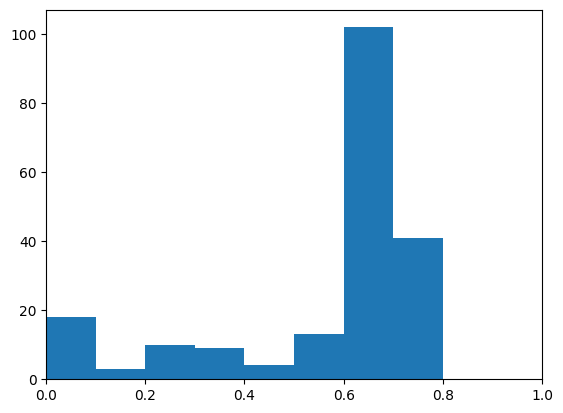

In [3]:
plt.xlim(0, 1)
plt.hist(losses // 0.1 * 0.1, bins=[0.1 * i for i in range(11)])
plt.savefig("hist_200.png")

<BarContainer object of 200 artists>

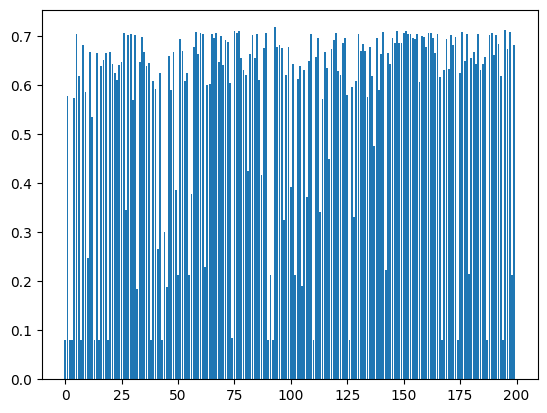

In [5]:
plt.bar(np.arange(len(losses)), losses)

In [17]:
regression = LinearRegression()
regression.fit(np.arange(len(losses)).reshape(-1, 1), losses)
print(f'{round(regression.coef_[0] * 100, 3)}%')
print(regression.intercept_)
print(np.mean(losses))

0.072%
0.4912689844580305
0.5632755001454208
